In [1]:
#conda install ipykernel -y put this in the terminal to fix the module missing error 

#be able to draw a tree sequence just via editing the tables
import tskit
tables = tskit.TableCollection(sequence_length=1.0)
n = tables.nodes
#nodes
n.add_row(flags=1, population=-1, time=0)
n.add_row(flags=1, population=-1, time=0)
n.add_row(flags=1, population=-1, time=0)
n.add_row(flags=1, population=-1, time=0)
n.add_row(flags=1, population=-1, time=0.4)
n.add_row(flags=1, population=-1, time=0.7)
n.add_row(flags=1, population=-1, time=1)

# to make a straightforward tree: 
# tables.edges.add_row(left=0.0, right=1.0, parent=4, child=2) 
# tables.edges.add_row(left=0.0, right=1.0, parent=4, child=3)
# tables.edges.add_row(left=0.0, right=1.0, parent=5, child=0)
# tables.edges.add_row(left=0.0, right=1.0, parent=5, child=1)
# tables.edges.add_row(left=0.0, right=1.0, parent=6, child=4)
# tables.edges.add_row(left=0.0, right=1.0, parent=6, child=5)

#adding in something where the edges actually matter: 1/2 of the genome has one genealogy, 1/2 has another. It doesn't make a lot of sense re: biology but the concept of different chunks having different ancestry I figured out here 
tables.edges.add_row(left=0.0, right=0.5, parent=4, child=2)
tables.edges.add_row(left=0.0, right=0.5, parent=4, child=3)
tables.edges.add_row(left=0.0, right=0.5, parent=5, child=0)
tables.edges.add_row(left=0.0, right=0.5, parent=5, child=1)
tables.edges.add_row(left=0.0, right=0.5, parent=6, child=4)
tables.edges.add_row(left=0.0, right=0.5, parent=6, child=5)

tables.edges.add_row(left=0.5, right=1.0, parent=4, child=0) 
tables.edges.add_row(left=0.5, right=1.0, parent=4, child=1)
tables.edges.add_row(left=0.5, right=1.0, parent=5, child=2)
tables.edges.add_row(left=0.5, right=1.0, parent=5, child=3)
tables.edges.add_row(left=0.5, right=1.0, parent=6, child=4)
tables.edges.add_row(left=0.5, right=1.0, parent=6, child=5)

#sort step, to ensure that your tables are ordered correctly
tskit.TableCollection.sort(edge_start=0, self=tables, site_start=0, mutation_start=0) #in tskit docs, the self=tables portion is just *, so here I've assigned self the the variable name for all tables

#tree sequence that prints in terminal and you don't have to deal w/ vscode and svgs
ts = tables.tree_sequence()
for t in ts.trees():
  print(t.draw(format='unicode'))


   6   
 ┏━┻━┓ 
 5   ┃ 
┏┻┓  ┃ 
┃ ┃  4 
┃ ┃ ┏┻┓
0 1 2 3

   6   
 ┏━┻━┓ 
 ┃   5 
 ┃  ┏┻┓
 4  ┃ ┃
┏┻┓ ┃ ┃
0 1 2 3



number of samples for the runs 10
expected Tmrca: 1.8
mean tmrca, in generations/(ploidy*N): 1.7624329736511746 mean tmrca, in raw gens: 1762.4329736511745
total expected branch lengths 5435.714285714284 mean summed branch lengths: 5543.923944473369
mean expectation for the number of polymorphisms on the tree 5.435714285714284 mean lambda, over lambdas used for sampling 5.543923944473367 number of average polymorphisms actually on the trees 5.24
mean allele frequencies, from all sims binned {1: 2.03, 2: 0.84, 3: 0.63, 4: 0.36, 5: 0.36, 6: 0.28, 7: 0.31, 8: 0.23, 9: 0.2}
expected mean site frequency spectrum [2.0, 1.0, 0.6666666666666666, 0.5, 0.4, 0.3333333333333333, 0.2857142857142857, 0.25, 0.2222222222222222] mean allele frequencies from sims, averaged {1: 2.03, 2: 0.84, 3: 0.63, 4: 0.36, 5: 0.36, 6: 0.28, 7: 0.31, 8: 0.23, 9: 0.2}
        18         
  ┏━━━━━━┻━━━━━━┓  
  ┃            17  
  ┃          ┏━━┻━┓
  ┃         16    ┃
  ┃       ┏━━┻━━┓ ┃
  ┃      15     ┃ ┃
  ┃    ┏━━┻━┓

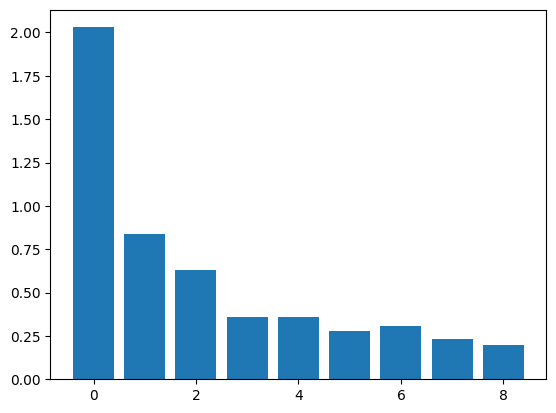

In [24]:
#make a no-recombination sim to get the stats right 
import msprime
import tskit 
import numpy as np
from numpy.random import default_rng
rng = default_rng()
import random
import seaborn as sns
import matplotlib.pyplot as plt
sequence_length = 100
mu = (1e-3) #normally would have this set to 1e-7 *2, but putting deme size down and #individuals up to be able to visualize tree sequences for working on placing mutations issue.
# sequence_length = 100
ploidy = 2
population_sequences = 1000 #total number of genomes in the population- the number of individuals is this/ploidy
sampled_sequences = 10
sim_runs = 100
#initialize the bottom two variables, to add/append to later 
mean_tmrca = 0
i_values = []
mean_summed_branch_lengths = []
total_mut_count = []
mut_expectations_given_branchlengths = []
for ts in msprime.sim_ancestry(ploidy= ploidy, samples=(sampled_sequences/ploidy), discrete_genome = True, population_size=(population_sequences)/ploidy, num_replicates = sim_runs, sequence_length = sequence_length): #the sim needs everything in terms of the number of individuals, but it's convenient for downstream/interpretation to have our original variables be in terms of the number of lineages or individual sequences, aka in haploid terms 
    assert ts.num_samples == sampled_sequences
    last_node = ts.num_nodes - 1
    tmrca = ts.node(last_node).time
    mean_tmrca += tmrca
    # print("tmrca for this run:", tmrca)
    newtables = ts.dump_tables() #modifying a copy of the original tables in order to be able to overwrite 
    #make a new table collection to hold everything
    average_genealogy_size = []
    for tree in ts.trees():
        # print(tree.draw(format='unicode'))
        interval = tree.interval #find the interval the tree occupies in the genome 
        # print(newtables.edges.child)
        nodes_and_branches = {} #empty dict to hold the pair of node:branch length to its parent
        for child_node in newtables.edges.child:
            nodes_and_branches.update({child_node:(tree.branch_length(child_node))}) 
        # print(nodes_and_branches)
        # print(nodes_and_branches.keys())
        summed_branch_lengths = sum(nodes_and_branches.values()) #hudson 1990, above equation 1. I could have just used the tskit function but I was going to loop over the nodes to make a dict anwyay 
        mean_summed_branch_lengths.append(summed_branch_lengths)
        proportional_branch_lengths = {} #empty dict to hold the pair of node:scaled branch length
        # print("sum of the lengths of all branches:", summed_branch_lengths, "what the tskit function gives you", sum(tree.branch_length(u) for u in tree.nodes()))
        # print("list of nodes in the tree that can have muts placed above them:", nodes_and_branches.keys()))
        for child_node in newtables.edges.child: #I probably can work around this and not have another loop by accessing the dictionary keys, but it doesn't seem worth the effort
            proportional_branch_lengths.update({child_node:(tree.branch_length(child_node)/summed_branch_lengths)}) #hudson 1990 equation 1
        # proportional_branch_lengths = dict(sorted(proportional_branch_lengths.items())) #sort the dictionary so the keys(representing nodes) go up in order. I thought this would matter for the np array step, but this may not help once we have >1 tree, as the incies of the np array will no longer match the dict
        # print("nodes and the branch lengths above them, proportional to the total length of all branches:" , proportional_branch_lengths) 
        #hudson 1990, equation 1: compare to the expectation of s above        
        lambda_total = mu*summed_branch_lengths #this is for what happens in our sim, but not the expectation
        genealogy_mutations = rng.poisson(lam=lambda_total)
        # print("number of mutations we sampled from poisson distribution:", genealogy_mutations, "mean number of mutations in the poisson distribution expectations for this tree", lambda_total)
        # print("proportional branch lengths:", proportional_branch_lengths)
        p = list(proportional_branch_lengths.values())
        if genealogy_mutations != 0:
            # print("genealogy contains more than 0 mutations")
            ###########sample nodes from your list of child nodes 
            nodes_sampled =  rng.choice(list(nodes_and_branches.keys()), p=p, size = genealogy_mutations) #this can sample the same node twice, which IS what you want. however need to figure out a way to determine which parent node was associated with a given branch length, so you can select a site that makes sense given the edges possible for a child:parent node relationship. int is a pretty crude 
            # print("nodes sampled from distribution, aka chosen to have mutations", nodes_sampled)
            ###########pick out the spot in the genome that the tree we have iterated over actually occupies (with edges) 
            # print("interval this tree occupies", tree.interval) #access this to pick which sites are possible
            for child_node in nodes_sampled: #since I do a pretty much identical thing above, there's gotta be a way to combine the two, but I'll leave the stunts for later 
                ###########draw a site from the genome that HASN'T ALREADY had a mutation assigned to it.
                # print("node mutation is being added onto:", child_node) 
                possible_bases = set(range((int(interval.left)), int(interval.right))) #set them to integers for now? need to figure out how to actually implement using sets 
                bases_already_mutated = set(int(i) for i in newtables.sites.position)
                unmutated_sites =(possible_bases.difference(bases_already_mutated)) #get the 
                position = np.random.randint(low=(interval.left), high=(int(interval.right)), size=1)
                position = position[0]
                # print("position of new mut:", position)
                ############use these nodes to write mutations to the mutations table
                # print("position", position)
                if position in unmutated_sites: #size should be 1, since we're only placing one mutation above each loop over a node
                    site_id = newtables.sites.add_row(position=position, ancestral_state="0")
                    # print("id of the site we are adding", site_id)
                    #####get times for the mutations- randomly select them from the interval between parent and child node times 
                    #get child node time
                    child_time = newtables.nodes.time[child_node]
                    # print("node ID", child_node,  ts.tables.edges.child[child_node])#https://stackoverflow.com/questions/176918/finding-the-index-of-an-item-in-a-
                    #now, find the parent node that goes with the child node: 
                    index = np.where(newtables.edges.child==child_node)[0][0] #https://www.geeksforgeeks.org/how-to-find-the-index-of-value-in-numpy-array/
                    # print("index of the table entry:", index, "that contains this child node:", child_node)
                    parent_node = newtables.edges.parent[index]
                    # print("parent node", parent_node)
                    parent_time = newtables.nodes.time[parent_node]
                    # print("time", child_time, "of the child node", child_node, "time of the parent node", parent_time)
                    time = np.random.uniform(low=child_time, high=parent_time)
                    # print("time the mutation has been randomly selected to have", time)
                    newtables.mutations.add_row(site=site_id, node=child_node, time=time, derived_state = "1") #this doesn't work as with the above-- perhaps something with the strings. 
                    # print(tskit.unpack_strings(newtables.sites.ancestral_state, newtables.sites.ancestral_state_offset))
                    # elif genealogy_mutations == 0:
                    #   print("genealogy does not contain any mutations")
            # print(newtables.mutations)
    
    newtables.sort(edge_start=0, mutation_start=0, site_start=0)
    new_ts = newtables.tree_sequence()
    ####do sfs stats
    # print(newtables.mutations)
    total_mut_count.append(len(newtables.mutations))
    mut_expectations_given_branchlengths.append(lambda_total)
    for tree in new_ts.trees():
        average_genealogy_size.append(tree.branch_length)
        for mutation in tree.mutations():
            # print("looking at mutation on node:", mutation.node) 
            count = tree.num_samples(mutation.node)
            # print("mutation count:", count)
            i_values.append(count) #dumping all i values into 
    # print("values for i, the number of occurences of a mutation", i_values)
    # print("one loop of a sim::", "mutation numbers:", genealogy_mutations, "occurrences of these mutations", i_values)
    # return [genealogy_mutations, lambda_total, i_values]
# print(newtables)





print("number of samples for the runs", ts.num_samples) #confusing that ts.num_samples is for haploid lineages, while samples in sim_ancestry is for individuals (which may not be haploid, and defaults to diploid). Note that this will be representative of the last loop over which tree sequence we're dealing with
#theoretical expectation for time to MRCA in units of 2N generations:
expected_tmrca = 2*(1-(1/sampled_sequences))
print("expected Tmrca:", expected_tmrca)
print("mean tmrca, in generations/(ploidy*N):", mean_tmrca/sim_runs/population_sequences, "mean tmrca, in raw gens:", mean_tmrca/sim_runs) #the first value is generations/(ploidy*N),and the second is in generations.
#expected time that i lineages should exist: T(i) =  4N/i(i-1) (hudson 2015, #2)
#sum i*(T(i)) from i=2 to n to get the total expected branch lengths: (above equation 6, hudson 1990)
expected_total_length = 0
for i in range(2, sampled_sequences):
    expected_total_length += i*((4*(population_sequences/ploidy)/(i*(i-1))))

print("total expected branch lengths", expected_total_length, "mean summed branch lengths:", (sum(mean_summed_branch_lengths)/sim_runs))
#now, we can use this to find the expected total number of polymorphisms (hudson 1990 eq1)
expected_lambda = mu*expected_total_length
print("mean expectation for the number of polymorphisms on the tree", expected_lambda, "mean lambda value, from lambdas used for sampling", sum(mut_expectations_given_branchlengths)/sim_runs, "number of average polymorphisms actually on the trees", (sum(total_mut_count))/sim_runs)
#sfs stats
theta = 4*(population_sequences/ploidy)*mu

# print("mutation counts from all loops", i_values)
mean_counts = {}
for i in range(1, ((sampled_sequences))): #in eq 6 the range is from 1 to n-1, but due to the vagaries of python ranges this will produce that even though it doesn't *look* like it.
    mean = (i_values.count(i))/sim_runs
    mean_counts.update({i:mean})
# mean_allele_freqs = (i_values.count(i))/sim_runs
print("mean allele frequencies, from all sims binned", mean_counts)
# # print("average number of mutations in sims", sum(mutations_in_run)/sim_runs, "expected mean number of mutations", expected_mutations)
print("expected mean site frequency spectrum", [(theta/i) for i in range(1, sampled_sequences)], "mean allele frequencies from sims, averaged", mean_counts)
ind = np.arange(len(mean_counts))
plt.bar(ind, list(mean_counts.values()))
for t in new_ts.trees():
  print(t.draw(format='unicode'))


list of tree sizes [5468.627875016006, 5732.461024345639, 5879.465889978078, 5755.0991820287545, 4905.117462495772] list of sizes, weighted by how much of the genome they occupy: [1203.0981325035214, 1203.8168151125842, 1763.8397669934234, 805.7138854840257, 637.6652701244504]
value of T 5614.1338702180055
mutation mean expectation: 561413.3870218005
break between loops over a sim
mean expectation for the number of polymorphisms on the tree 561413.3870218005 mean lambda, over lambdas used for sampling 0.0 number of average polymorphisms actually on the trees 5.0
expected mean site frequency spectrum [2.0, 1.0, 0.6666666666666666, 0.5, 0.4, 0.3333333333333333, 0.2857142857142857, 0.25, 0.2222222222222222] mean allele frequencies from sims, averaged {1: 2.0, 2: 1.0, 3: 0.0, 4: 2.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.0}
            22     
        ┏━━━━┻━━━━┓
       21         ┃
    ┏━━━┻━━━━┓    ┃
    ┃   

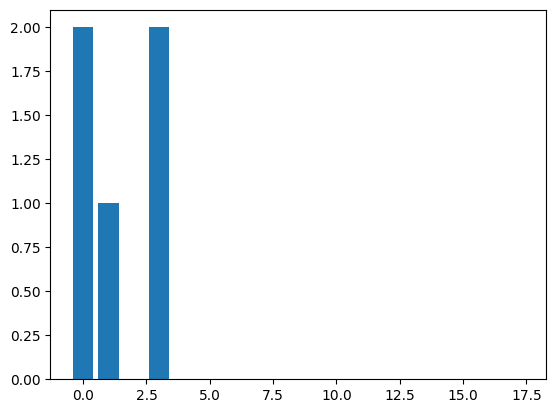

In [19]:
#do the above with multiple trees
import msprime
import tskit 
import numpy as np
from numpy.random import default_rng
rng = default_rng()
import random
import seaborn as sns
import matplotlib.pyplot as plt
sequence_length = 100
mu = (1e-3) #normally would have this set to 1e-7 *2, but putting deme size down and #individuals up to be able to visualize tree sequences for working on placing mutations issue.
# sequence_length = 100
ploidy = 2
population_sequences = 1000 #total number of genomes in the population- the number of individuals is this/ploidy
sampled_sequences = 10
sim_runs = 1
rho = (1e-6)*5
#initialize the bottom two variables, to add/append to later 
mean_tmrca = 0
i_values = []
mean_summed_branch_lengths = []
total_mut_count = []
mean_expected_lambda = []


for ts in msprime.sim_ancestry(ploidy= ploidy, samples=(sampled_sequences/ploidy), discrete_genome = True, population_size=(population_sequences)/ploidy, num_replicates = sim_runs, sequence_length = sequence_length, recombination_rate=rho): #the sim needs everything in terms of the number of individuals, but it's convenient for downstream/interpretation to have our original variables be in terms of the number of lineages or individual sequences, aka in haploid terms 
    newtables = ts.dump_tables() #modifying a copy of the original tables in order to be able to overwrite 
    assert ts.num_samples == sampled_sequences
    last_node = ts.num_nodes - 1
    tmrca = ts.node(last_node).time
    mean_tmrca += tmrca
    # print("tmrca for this run:", tmrca)
    # print(ts.draw_text())
    # print(newtables.edges)
    genealogy_sizes = []
    weighted_genealogy_sizes = []
    genealogy_sizes = []
    sequence_weights = []
    for tree in ts.trees():
        # print(tree.draw(format='unicode'))
        current_tree_interval = tree.interval #find the interval the tree occupies in the genome 
        span = tree.interval.right-tree.interval.left #find the fraction of the total genome/number of bases, for multiple trees 
        # print(newtables.edges)
        # print("interval this tree exists on", current_tree_interval)
        nodes_and_branches = {} #empty dict to hold the pair of node:branch length to its parent. each tree gets its own list of these 
        for node in tree.nodes(): #needed in the recombination version of the sim due to not all nodes being present in all trees 
            for child_node in newtables.edges.child:
                if child_node ==node: 
                    nodes_and_branches.update({child_node:(tree.branch_length(child_node))}) 
                    
        # x = (list(nodes_and_branches.keys()))
        # x.sort()
        # print("list of non-root nodes in the tree (ones that can have muts placed on them):", x)
        summed_branch_lengths = sum(nodes_and_branches.values()) #hudson 1990, above equation 1. I could have just used the tskit function but I was going to loop over the nodes to make a dict anwyay 
        mean_summed_branch_lengths.append(summed_branch_lengths)
        proportional_branch_lengths = {} #empty dict to hold the pair of node:scaled branch length
        # print("sum of the lengths of all branches:", summed_branch_lengths, "what the tskit function gives you", sum(tree.branch_length(u) for u in tree.nodes()))
        # print("list of nodes in the tree that can have muts placed above them:", child_nodes_list)
        for node in tree.nodes():
            for child_node in newtables.edges.child: #I probably can work around this and not have another loop by accessing the dictionary keys, but it doesn't seem worth the effort
                if child_node == node: 
                    proportional_branch_lengths.update({child_node:(tree.branch_length(child_node)/summed_branch_lengths)}) #hudson 1990 equation 1
        # print(proportional_branch_lengths)
        # proportional_branch_lengths = dict(sorted(proportional_branch_lengths.items())) #sort the dictionary so the keys(representing nodes) go up in order. I thought this would matter for the np array step, but this may not help once we have >1 tree, as the incies of the np array will no longer match the dict
        # print("nodes and the branch lengths above them, proportional to the total length of all branches:" , proportional_branch_lengths) 
        #hudson 1990, equation 1: compare to the expectation of s above        
        lambda_tree = mu*summed_branch_lengths*(span/sequence_length) #hudson 1990 eq 1
        tree_mutations = rng.poisson(lam=lambda_tree)
        # print("number of mutations we sampled from poisson distribution:", genealogy_mutations, "mean number of mutations in the poisson distribution expectations for this tree", lambda_total)
        # print("proportional branch lengths:", proportional_branch_lengths)
        p = list(proportional_branch_lengths.values())
        # print("child nodes", len(child_nodes_list))
        # print("proportional branch lengths", p, "sum", sum(p))
 
        if tree_mutations != 0:
            # print("genealogy contains more than 0 mutations")
            ###########sample nodes from your list of child nodes 
            nodes_sampled =  rng.choice(list(nodes_and_branches.keys()), p=p, size=tree_mutations) #this can sample the same node twice, which IS what you want. however need to figure out a way to determine which parent node was associated with a given branch length, so you can select a site that makes sense given the edges possible for a child:parent node relationship. int is a pretty crude 
            # print("nodes sampled from distribution, aka chosen to have mutations", nodes_sampled)
            ###########pick out the spot in the genome that the tree we have iterated over actually occupies (with edges) 
            # print("interval this tree occupies", current_tree_interval) #access this to pick which sites are possible
            for child_node in nodes_sampled: #since I do a pretty much identical thing above, there's gotta be a way to combine the two, but I'll leave the stunts for later 
                ###########draw a site from the genome that HASN'T ALREADY had a mutation assigned to it.
                # print("node mutation is being added onto:", child_node) 
                possible_bases = set(range((int(current_tree_interval.left)), int(current_tree_interval.right))) #set them to integers for now? need to figure out how to actually implement using sets 
                bases_already_mutated = set(int(i) for i in newtables.sites.position)
                unmutated_sites =(possible_bases.difference(bases_already_mutated)) #get the 
                position = np.random.randint(low=(current_tree_interval.left), high=(int(current_tree_interval.right)), size=1) #looks like this is working fine for 
                position = position[0]
                # print("position of new mut:", position)
                ############use these nodes to write mutations to the mutations table
                if position in unmutated_sites: #size should be 1, since we're only placing one mutation above each loop over a node
                    site_id = newtables.sites.add_row(position=position, ancestral_state="0")
                    # print("id of the site we are adding", site_id)
                    #####get times for the mutations- randomly select them from the interval between parent and child node times 
                    # get child node time
                    child_time = newtables.nodes.time[child_node]
                    # print("node ID", child_node,  ts.tables.edges.child[child_node])#https://stackoverflow.com/questions/176918/finding-the-index-of-an-item-in-a-
                    #now, find the parent node that goes with the child node: 
                    index = np.where(newtables.edges.child==child_node)[0] #https://www.geeksforgeeks.org/how-to-find-the-index-of-value-in-numpy-array/
                    # print("child node", child_node, "row in edge tables", index)
                    entries = newtables.edges[index]
                    # print(entries)
                    for row_id in index:
                        entry = newtables.edges[row_id]
                        # print("indices of the edge table entry", row_id, "that contains this child node:", child_node, "full entry:", entry)
                        if (entry.left) == current_tree_interval.left:   
                            if entry.right == current_tree_interval.right: #if the interval matches the interval of the tree we're looping over exactly
                                # print("entry that is actually in current tree interval", entry)
                                parent_node = entry.parent
                                parent_time = newtables.nodes.time[parent_node]
                            elif entry.right >= current_tree_interval.right: 
                                parent_node = entry.parent
                                parent_time = newtables.nodes.time[parent_node]  
                        elif entry.left <= current_tree_interval.left:
                            if entry.right >= current_tree_interval.right: #if the tree sequence is contained entirely within the entry interval
                                parent_node = entry.parent
                                parent_time = newtables.nodes.time[parent_node]
                        elif (entry.left, entry.right) == (0, sequence_length): #this happens when the node is not associated with a recombination event 
                            # print("this node has the same parent regardless of tree") #do I need to do this above??)
                            parent_node = entry.parent
                            parent_time = newtables.nodes.time[parent_node]
                        # print("parent node", parent_node)
                    # print(newtables.nodes)
                    # print("time", child_time, "of the child node", child_node, "time", parent_time, "of the parent node", parent_node)
                    time = np.random.uniform(low=child_time, high=parent_time)
                    # print("time the mutation has been randomly selected to have", time)
                    newtables.mutations.add_row(site=site_id, node=child_node, time=time, derived_state = "1") #this doesn't work as with the above-- perhaps something with the strings. 
                    # print(tskit.unpack_strings(newtables.sites.ancestral_state, newtables.sites.ancestral_state_offset))
        # elif tree_mutations == 0:
            # print("tree does not contain any mutations")\
        ##########expected number of mutations:hudson p. 17
        #average all the sizes of the genealogies of each tree together:
        genealogy_sizes.append(summed_branch_lengths) 
        sequence_weights.append(span/sequence_length)
        weighted_genealogy_sizes.append(summed_branch_lengths*(span/sequence_length)) #multiply the size of the genealogy * the proportion of the genome it occupies 

    ########find the size of the tree's genealogy, weighted by its length:
    print("list of tree sizes", genealogy_sizes, "list of sizes, weighted by how much of the genome they occupy:", weighted_genealogy_sizes)
    T_value = sum(weighted_genealogy_sizes)/sum(sequence_weights)
    print("value of T", T_value)
    #making sure the method above works
    # print("make sure the above numbers are correct:", sequence_weights, genealogy_sizes)
    # for i, value in enumerate(genealogy_sizes):
    #     print("Calculation", genealogy_sizes[i]*sequence_weights[i])
    # average_tree_size = sum(weighted_genealogy_sizes)
    theta = 4*(population_sequences/ploidy)*mu
    expected_mean_number_mutations = (T_value * (4*(population_sequences/ploidy)*(mu*sequence_length))) / 2 #for recombination, p. 17 in hudson 1990
    print("mutation mean expectation:", expected_mean_number_mutations)
    mean_expected_lambda.append(expected_mean_number_mutations)

    #am I calculating T wrong? where we want an average weight????


    
    
    newtables.sort(edge_start=0, mutation_start=0, site_start=0)
    new_ts = newtables.tree_sequence()
    ####do sfs stats
    total_mut_count.append(len(newtables.mutations))
    # mut_expectations_given_branchlengths.append(lambda_total)
    for tree in new_ts.trees():
        for mutation in tree.mutations():
            # print("looking at mutation on node:", mutation.node) 
            count = tree.num_samples(mutation.node)
            # print("mutation count:", count)
            i_values.append(count) #dumping all i values from multiple sim runs
    # print("values for i, the number of occurences of a mutation", i_values)
    # print("one loop of a sim::", "mutation numbers:", genealogy_mutations, "occurrences of these mutations", i_values)
    print("break between loops over a sim")
    


# print(newtables)
# print(newtables.mutations)
# print("number of samples for the runs", ts.num_samples) #confusing that ts.num_samples is for haploid lineages, while samples in sim_ancestry is for individuals (which may not be haploid, and defaults to diploid). Note that this will be representative of the last loop over which tree sequence we're dealing with
#theoretical expectation for time to MRCA in units of 2N generations:
# expected_tmrca = 2*(1-(1/samples))
# print("expected Tmrca:", expected_tmrca)
# print("mean tmrca, in generations/(ploidy*N):", mean_tmrca/sim_runs/population_sequences, "mean tmrca, in raw gens:", mean_tmrca/sim_runs) #the first value is generations/(ploidy*N),and the second is in generations.
#expected time that i lineages should exist: T(i) =  4N/i(i-1) (hudson 2015, #2)
#sum i*(T(i)) from i=2 to n to get the total expected branch lengths: (above equation 6, hudson 1990)
expected_total_length = 0
for i in range(2, sampled_sequences):
    expected_total_length += i*((4*(population_sequences/ploidy)/(i*(i-1))))

# print("total expected branch lengths", expected_total_length, "mean summed branch lengths:", (sum(mean_summed_branch_lengths)/sim_runs))
#now, we can use this to find the expected total number of polymorphisms (hudson 1990 eq1)
expected_lambda = mu*expected_total_length
# print("mean expectation for the number of polymorphisms on the tree", expected_lambda)


#sfs stats
theta = 4*(population_sequences/ploidy)*mu
# print("mutation counts from all loops", i_values)
mean_counts = {}
for i in range(1, ((sampled_sequences*2)-1)):
    mean = (i_values.count(i))/sim_runs
    mean_counts.update({i:mean})
# mean_allele_freqs = (i_values.count(i))/sim_runs
# print("mean allele frequencies, from all sims binned", mean_counts)
# # print("average number of mutations in sims", sum(mutations_in_run)/sim_runs, "expected mean number of mutations", expected_mutations)
expected_lambda = mu*expected_total_length
print("mean expectation for the number of polymorphisms on the tree", sum(mean_expected_lambda)/sim_runs, "mean lambda, over lambdas used for sampling", sum(mut_expectations_given_branchlengths)/sim_runs, "number of average polymorphisms actually on the trees", (sum(total_mut_count))/sim_runs)
print("expected mean site frequency spectrum", [(theta/i) for i in range(1, sampled_sequences)], "mean allele frequencies from sims, averaged", mean_counts)
ind = np.arange(len(mean_counts))
plt.bar(ind, list(mean_counts.values()))
for t in new_ts.trees():
  print(t.draw(format='unicode'))

In [1]:
#kevin's script for how to deal with units of generations in msprime
import msprime

nreps = 10000

for ploidy in [1, 2, 5, 10]:
    mean = 0
    # Here is where it (the interface) gets confusing.
    # We simulate 10 lineages.
    # But there's a GIANT gotcha:
    # population_size is number of INDIVIDUALS and not
    # the number of LINEAGES.
    # Therefore, we have to divied that by PLOIDY
    # to keep everything comparable.
    for ts in msprime.sim_ancestry(samples =(10/ploidy), population_size=1000/ploidy,
                                   ploidy=ploidy, model="hudson",
                                   num_replicates=nreps):
        assert ts.num_samples == 10 ##I forget this every time, but I think the point is ts.num_samples will return the number of sampled SEQUENCES, while 
        last_node = ts.num_nodes - 1
        tmrca = ts.node(last_node).time
        mean += tmrca

    # Now, the first value is generations/(ploidy*N),
    # And the second is in generations.
    print(mean/nreps/1000, mean/nreps)

# Divide out the ploidy
ts = msprime.sim_ancestry(samples = 5, population_size=1000/2,
                          ploidy=ploidy, model="hudson")
last_node = ts.num_nodes - 1
tmrca = ts.node(last_node).time

# needs tskit 0.5.4!!!!!!!!!!!!!!!!!!!!!!!!!
ts.draw_svg(path="test.svg", y_axis=True, size=(
    600, 600), canvas_size=(800, 800))
print(tmrca) #in units of generations- we don't need to divide by the reps above because it's only one rep! Also shows how wide the variance is on that mean- not crazy to get 11,800 gens for the time when the expectation is 1,800 gens, or 1.8 in units gens/ploidy*N 

#these should all come up with the theoretical expectation: for ploidy and n
# print(2*(1-(1/10)))
# print(2*(1-1/10)) #me, seeing how 'smart' python is with orders of operation
# print(2*(1-1/2))

1.7912818296162087 1791.2818296162088
1.822813472845434 1822.813472845434
1.8013986092376217 1801.3986092376217
1.797466850685748 1797.466850685748
4888.190532188829


In [9]:
#mak

In [8]:
#make a standalone tree sequence to learn how to do the mutation placement, make sim predictions, etc
import msprime
import tskit
import numpy as np
from numpy.random import default_rng
rng = default_rng()
import random
#simulate one population fo now
mu = (1e-1) #normally would have this set to 1e-7 *2, but putting deme size down and #individuals up to be able to visualize tree sequences for working on placing mutations issue.
rho = (1e-4)*2
bases = 1000
deme_size = 100
ts = msprime.sim_ancestry(recombination_rate=rho, sequence_length = bases, samples=2, random_seed=1234, discrete_genome = True)
newtables = ts.dump_tables() #modifying a copy of the original tables in order to be able to overwrite 
#make a new table collection to hold everything
for tree in ts.trees():
    nodes_list = np.zeros(tree.tree_sequence.num_nodes) #make a np array for each node to track the branch lengths above it (needed for calculations around placing mutations)
    branch_lengths = np.zeros(tree.tree_sequence.num_nodes) #need two np arrays initiated with the same number- one for branch lengths, and one to keep track of the nodes
    summed_branch_lengths = 0
    interval = tree.interval #find the interval the tree occupies in the genome 
    span = tree.interval.right-tree.interval.left #find the fraction of the total genome/number of bases
    
    for node in tree.nodes(): #type error: tree object is not iterable-- this happens w/ you frequently b/c you're forgetting to include the parenthesis to call the method properly, so the code tries to iterate over the method and not the data structure it's referencing 
        branch_lengths[node] =+ tree.branch_length(node)  #https://stackoverflow.com/questions/43505921/python-trying-to-create-a-dictionary-through-a-for-loop
        nodes_list[node] =+ node
        child_time = newtables.nodes.time[node]

        for index, child_node in enumerate(newtables.edges.child):
            if child_node == node:
                # print("index of edgetable entry", index, "child node", child_node)
                # print("index of edgetable entry", index, "child node", child_node)
                entry = newtables.edges[index]
                # print("entry that matches a node in this tree", entry)
                # print("line of edgetable accessed", index, "child node for this loop", child_node, "edgetable entry", entry)
                current_tree_interval = (interval.left, interval.right)
                if (entry.left, entry.right) == current_tree_interval: 
                    parent_node = entry.parent
                    parent_time = newtables.nodes.time[parent_node]
                    branch_length = (parent_time - child_time)    
                    summed_branch_lengths = summed_branch_lengths + branch_length #hudson 1990, above equation 1
                    ####place mutations on nodes proportional to branch lengths, and proportional to how long of a span of the genome a given tree occupies
                    lambda_lineage = mu *branch_length *(span/bases) #my idea to populate the sim with the expected number of mutations given the parameters I'm using: get mu * t in here, after the hudson 2015 paper having lineage mu * branch length be the number of mutations occuring along that lineage. Summing them all up to get expectations for each tree. I'm multiplying by the fraction of the genome, since I believe mu* branch length as the expectation for the # of mutations assumes the whole genome

    print("nodes in the current tree", nodes_list)
    lambda_total = mu*summed_branch_lengths*(span/bases)
    genealogy_mutations = rng.poisson(lam=lambda_total)
    print("mean number of mutations expected on this tree/poisson lambda", lambda_total, "number of mutations drawn from poisson distribution", genealogy_mutations)
    print("fraction of the genome this tree occupies", span/bases)
    print("summed branch lengths:", summed_branch_lengths)
    proportional_branch_lengths = branch_lengths/summed_branch_lengths 
    p = np.asarray(proportional_branch_lengths).astype('float64')
    p = p/np.sum(p) #not sure if doing this as a workaround to the proportional branch lengths array not summing to 0 is the best idea, but to get it working for now
    # print("probabilities",p, "sums", sum(p))

    #######temporarily hardcoding in some mutations to test the below, changed size = int(number_mutations) to size = 3
    nodes_sampled =  rng.choice(nodes_list, p=p, size = genealogy_mutations) #this can sample the same node twice, which IS what you want. however need to figure out a way to determine which parent node was associated with a given branch length, so you can select a site that makes sense given the edges possible for a child:parent node relationship. int is a pretty crude 
    # nodes_sampled =  np.random.choice(nodes_list, p=p, size = np.random.choice(expected mutations))

    nodes_sampled = nodes_sampled.astype(int) ##these need to be integers to be able to use them to access indices/values in the edge table. See if you can make it such when the  variable is created 
    # print("nodes sampled from distribution", nodes_sampled)
    #pick out the spot in the genome that the tree we have iterated over actually occupies (with edges) 
    print("interval this tree occupies", tree.interval) #access this to pick which sites are possible
    # print("left side of interval", interval.left)
    for node in nodes_sampled: #since I do a pretty much identical thing above, there's gotta be a way to combine the two, but I'll leave the stunts for later 
        ######draw a site from the genome that HASN'T ALREADY had a mutation assigned to it. 
        #use these nodes to write mutations to the mutations table
        possible_bases = set(range((int(interval.left)), int(interval.right))) #set them to integers for now? need to figure out how to actually implement using sets 
        bases_already_mutated = set(int(i) for i in newtables.sites.position)
        unmutated_sites =(possible_bases.difference(bases_already_mutated)) #get the difference between two sets- it returns only those bases NOT in bases_already_mutated
        # print("checking if unmutated sites are constrained to those within the tree", unmutated_sites)
        # print("set difference test", x)
        # position = np.random.choice(tuple(unmutated_sites))#suggestion from one stackoverflow entry for this(https://stackoverflow.com/questions/15837729/random-choice-from-set-python) links to another to try to make this process constant time???: https://stackoverflow.com/questions/15993447/python-data-structure-for-efficient-add-remove-and-random-choice
        # print(position)
        ######add binary mutations in- 0/1, whether it's been mutated or not. Or could use just two nucleotides, for instance
        # print("SITES THAT DO NOT YET HAVE A MUTATION", unmutated_sites)
        ###suggestion for how to make it faster
        position = np.random.randint(low=(interval.left), high=(int(interval.right)), size=1)
        position = position[0]
        print(position)
        if position in unmutated_sites: #size should be 1, since we're only placing one mutation above each loop over a node
            newtables.sites.add_row(position=position, ancestral_state="0")

        #####get times for the mutations- randomly select them from the interval between parent and child node times 
        #get child node time
        child_time = newtables.nodes.time[node]
        # print("node ID", node,  ts.tables.edges.child[node])#https://stackoverflow.com/questions/176918/finding-the-index-of-an-item-in-a-
        
        for index, child_node in enumerate(newtables.edges.child): #I think the child node is the appropriate one to pick, since we chose nodes BELOW branches. Mutations are associated with the node below them (according to tskit data model page)
            # print(index, j) #this print statement coupled with the one below lets you check if it's behaving as intended
            if child_node == node:
                entry = newtables.edges[index]
                # print("node", node, "edges associated with the node selected", entry)
                current_tree_interval = (interval.left, interval.right)
                if (entry.left, entry.right) == current_tree_interval: 
                    parent_node = entry.parent
                    # print("tuple matched, parent node", parent_node)
                elif (entry.left, entry.right) == (0, bases): #this happens when the node is not associated with a recombination event 
                    # print("this node has the same parent regardless of tree") (#do I need to do this above??)
                    parent_node=entry.parent

        #now, find actual parent time:
        parent_time = newtables.nodes.time[parent_node]
        # print("parent time", parent_time)
        time_span = (child_time, parent_time)
        # print("time interval between a node and its parent", time_span)
        time=random.choice(time_span) #you get a suspiciously high amount of '0' times. 

        #####assign all variables to the mutations table 
        newtables.mutations.add_row(site=position, node=node, time=time, derived_state = "1") #this doesn't work as with the above-- perhaps something with the strings. 
        # print(tskit.unpack_strings(newtables.sites.ancestral_state, newtables.sites.ancestral_state_offset))

        # print(np.setdiff1d(nucleotides, newtables.sites.ancestral_state))
    print("LOOP BREAK between trees", "\n")


    expected_sfs = []
    theta = 4*(deme_size)*(mu)
    for i in range(1,10):
        expected_sfs.append(theta/i)
    print("Expected site frequency spectrum", expected_sfs)

# mutations expected for whole genome: 



print("loop break between trees")
print(newtables)
# simulated_sfs = []
# a = ts.allele_frequency_spectrum(sample_sets=[ts.samples(population=1), ts.samples(population=2)], windows=None, mode='site', span_normalise=True, polarised=False)
# print("allele frequency spectrum function", a)

for t in ts.trees():
  print(t.draw(format='unicode'))


newtables.sort()

# new_ts = newtables.tree_sequence()
# for t in new_ts.trees():
#   print(t.draw(format='unicode'))


nodes in the current tree [0. 1. 2. 3. 4. 5. 6. 0.]
mean number of mutations expected on this tree/poisson lambda 0.4709072046998257 number of mutations drawn from poisson distribution 0
fraction of the genome this tree occupies 0.545
summed branch lengths: 8.64049916880414
interval this tree occupies Interval(left=0.0, right=545.0)
LOOP BREAK between trees 

Expected site frequency spectrum [40.0, 20.0, 13.333333333333334, 10.0, 8.0, 6.666666666666667, 5.714285714285714, 5.0, 4.444444444444445]
nodes in the current tree [0. 1. 2. 3. 4. 5. 0. 7.]
mean number of mutations expected on this tree/poisson lambda 0.9707031794118754 number of mutations drawn from poisson distribution 2
fraction of the genome this tree occupies 0.455
summed branch lengths: 21.334135811250007
interval this tree occupies Interval(left=545.0, right=1000.0)
893
912
LOOP BREAK between trees 

Expected site frequency spectrum [40.0, 20.0, 13.333333333333334, 10.0, 8.0, 6.666666666666667, 5.714285714285714, 5.0, 4.44

LibraryError: Site out of bounds. (TSK_ERR_SITE_OUT_OF_BOUNDS)